# Maren Equations Summary

This notebook is just pulling out the important figures and tables for the manuscript. For more detailed explanations and exploring see other notebooks.

In [1]:
# Set-up default environment
%run '../ipython_startup.py'

# Import additional libraries
import sas7bdat as sas
import cPickle as pickle
import statsmodels.formula.api as smf

from ase_cisEq import marenEq
from ase_cisEq import marenPrintTable

from ase_normalization import meanCenter
from ase_normalization import q3Norm
from ase_normalization import meanStd

pjoin = os.path.join

Importing commonly used libraries: 
            os, sys 
            numpy as np 
            scipy as sp 
            pandas as pd 
            matplotlib as mp 
            matplotlib.pyplot as plt
            datetime as dt 
            mclib_Python/flagging as fg

Creating project level variables: 
        MCLAB = /home/jfear/mclab 
        PROJ = /home/jfear/mclab/cegs_ase_paper 
        TODAY = 20150929

Adding ['scripts/mclib_Python', 'scripts/ase_Python'] to PYTHONPATH



## Import clean data set

This data set was created by: ase_summarize_ase_filters.sas

The data has had the following droped:
* regions that were always bias in 100 genome simulation
* regions with APN $\le 25$
* regions not in at least 10% of genotypes
* regions not in mated and virgin
* genotypes with extreme bias in median(q5_mean_theta)
* genotypes with $\le500$ regions

In [2]:
# Import clean dataset
with sas.SAS7BDAT(pjoin(PROJ, 'sas_data/clean_ase_stack.sas7bdat')) as FH:
    df = FH.to_data_frame()
    
dfClean = df[['line', 'mating_status', 'fusion_id', 'flag_AI_combined', 'q5_mean_theta', 'sum_both', 'sum_line', 'sum_tester', 'sum_total', 'mean_apn']]
print 'Rows ' + str(dfClean.shape[0])
print 'Columns ' + str(dfClean.shape[1])
print 'Number of Genotypes ' + str(len(set(dfClean['line'].tolist())))
print 'Number of Exonic Regions ' + str(len(set(dfClean['fusion_id'].tolist())))

[clean_ase_stack.sas7bdat] header length 65536 != 8192


Rows 159934
Columns 10
Number of Genotypes 49
Number of Exonic Regions 5391


### Additional cleaning
For the maren equations, I am also going to drop exonic regions with less than 10 genotypes. The maren equations make some assumptions about the population level sums. Obvisouly the more genotypes that are present for each fusions the better, but I am comfortable with as few as 10 genotypes.

In [3]:
# Drop groups with less than 10 lines per fusion
grp = dfClean.groupby(['mating_status', 'fusion_id'])
dfGt10 = grp.filter(lambda x: x['line'].count() >= 10).copy()
print 'Rows ' + str(dfGt10.shape[0])
print 'Columns ' + str(dfGt10.shape[1])
print 'Number of Genotypes ' + str(len(set(dfGt10['line'].tolist())))
print 'Number of Exonic Regions ' + str(len(set(dfGt10['fusion_id'].tolist())))

Rows 131700
Columns 10
Number of Genotypes 49
Number of Exonic Regions 3053


## Raw Counts

In [4]:
# Calculate Maren TIG equations by mating status and exonic region
marenRawCounts = marenEq(dfGt10, Eii='sum_line', Eti='sum_tester', group=['mating_status', 'fusion_id'])
marenRawCounts['mag_cis'] = abs(marenRawCounts['cis_line'])
marenRawCounts.columns

Index([            u'line',    u'mating_status',        u'fusion_id',
       u'flag_AI_combined',    u'q5_mean_theta',         u'sum_both',
               u'sum_line',       u'sum_tester',        u'sum_total',
               u'mean_apn',               u'mu',         u'cis_line',
             u'trans_line',       u'cis_tester',     u'trans_tester',
                u'mag_cis'],
      dtype='object')

In [ ]:
marenRawCounts

### Plot Distribution of *cis*- and *trans*-effects

In [5]:
# Plot densities
def panelKde(df, **kwargs):
    options = {'subplots': True, 
               'layout': (7, 7), 
               'figsize': (20, 20), 
               'xlim': (-500, 500), 
               'legend': False,
               'color': 'k'}
    options.update(kwargs)
    
    # Make plot
    axes = df.plot(kind='kde', **options)
    
    # Add titles intead of legends
    try:
        for ax in axes.ravel():
            h, l = ax.get_legend_handles_labels()
            ax.set_title(l[0])
            ax.get_yaxis().set_visible(False)
            ax.axvline(0, lw=1)
    except:
        ax = axes
        ax.get_yaxis().set_visible(False)
        ax.axvline(0, lw=1)
    
    return plt.gcf()
    
def linePanel(df, value='cis_line', index='fusion_id', columns='line'):
    
    mymap = {
        'cis_line': 'cis-Line Effects',
        'trans_line': 'trans-Line Effects',
        'line': 'genotype',
        'fusion_id': 'exonic_region'
    }
    
    # Iterate over mated and virgin
    for k, v in {'M': 'Mated', 'V': 'Virgin'}.iteritems():
        
        # Pivot data frame so that the thing you want to make panels by is in columns.
        dfPiv = pd.pivot_table(df[df['mating_status'] == k], 
                               values=value, index=index, columns=columns)
        
        # Generate panel plot with at most 49 panels
        if value == 'cis_line':
            xlim = (-500, 500)
        else:
            # trans-effects appear to be larger in magnitude
            xlim = (-1500, 1500)
            
        fig = panelKde(dfPiv.iloc[:, :49], xlim=xlim)
        
        title = '{}\n{}'.format(mymap[value], v)
        fig.suptitle(title, fontsize=18, fontweight='bold')
        
        fname = pjoin(PROJ, 'pipeline_output/cis_effects/density_plot_by_{}_{}_{}.png'.format(mymap[columns], value, v.lower()))
        plt.savefig(fname, bbox_inches='tight')
        print("Saved figure to: " + fname)
        
        plt.close()
        
def testerPanel(df, value='cis_tester'):
    mymap = {
        'cis_tester': 'cis-Tester Effects',
        'trans_tester': 'trans-Trans Effects'
    }
    
    # Iterate over mated and virgin
    for k, v in {'M': 'Mated', 'V': 'Virgin'}.iteritems():
        
        # Split table by mating status and drop duplicates, because 
        # there is only one tester value for each exonic region
        dfSub = df.ix[df['mating_status'] == k,['fusion_id', value]].drop_duplicates()
        
        # Generate Panel Plot
        fig = panelKde(dfSub, subplots=False)
        
        title = '{}\n{}'.format(mymap[value], v)
        fig.suptitle(title, fontsize=18, fontweight='bold')
        
        fname = pjoin(PROJ, 'pipeline_output/cis_effects/density_plot_{}_{}.png'.format(value, v.lower()))
        plt.savefig(fname, bbox_inches='tight')
        print("Saved figure to: " + fname)
        
        plt.close()

In [7]:
# Cis and trans line effects by genotype
linePanel(marenRawCounts, value='cis_line', index='fusion_id', columns='line')
linePanel(marenRawCounts, value='trans_line', index='fusion_id', columns='line')

# Cis and trans line effects by exonic region
linePanel(marenRawCounts, value='cis_line', index='line', columns='fusion_id')
linePanel(marenRawCounts, value='trans_line', index='line', columns='fusion_id')

# Cis and trans tester effects
testerPanel(marenRawCounts, value='cis_tester')
testerPanel(marenRawCounts, value='trans_tester')

Saved figure to: /home/jfear/mclab/cegs_ase_paper/pipeline_output/cis_effects/density_plot_by_genotype_cis_line_mated.png
Saved figure to: /home/jfear/mclab/cegs_ase_paper/pipeline_output/cis_effects/density_plot_by_genotype_cis_line_virgin.png
Saved figure to: /home/jfear/mclab/cegs_ase_paper/pipeline_output/cis_effects/density_plot_by_genotype_trans_line_mated.png
Saved figure to: /home/jfear/mclab/cegs_ase_paper/pipeline_output/cis_effects/density_plot_by_genotype_trans_line_virgin.png
Saved figure to: /home/jfear/mclab/cegs_ase_paper/pipeline_output/cis_effects/density_plot_by_exonic_region_cis_line_mated.png
Saved figure to: /home/jfear/mclab/cegs_ase_paper/pipeline_output/cis_effects/density_plot_by_exonic_region_cis_line_virgin.png
Saved figure to: /home/jfear/mclab/cegs_ase_paper/pipeline_output/cis_effects/density_plot_by_exonic_region_trans_line_mated.png
Saved figure to: /home/jfear/mclab/cegs_ase_paper/pipeline_output/cis_effects/density_plot_by_exonic_region_trans_line_vir

### Plot *cis*- and *trans*-effects vs Allelic Proportion

In [14]:
# Set Globals
SHAPES = {'M': 'o', 'V': '^'}
CMAP='jet'

# Add color column to color by genotype
colors = {}
cnt = 0
genos = set(dfGt10['line'].tolist())
for l in genos:
    colors[l] = cnt
    cnt += 1

marenRawCounts['color'] = marenRawCounts['line'].map(colors)

In [15]:
# Plotting scatter
def getR2(df, x, y):
    """ Calculate the R-squared using OLS with an intercept """
    formula = '{} ~ {} + 1'.format(y, x)
    return smf.ols(formula, df).fit().rsquared

def scatPlt(df, x, y, c=None, cmap='jet', s=50, marker='o', ax=None, title=None, xlab=None, ylab=None, diag='pos'):
    """ Make a scatter plot using some default options """
    
    ax = df.plot(x, y, kind='scatter', ax=ax, c=c, cmap=cmap, s=s, marker=marker, title=title, colorbar=False)
    
    # Add a diag line
    if diag == 'neg':
        # draw a diag line with negative slope
        ax.plot([0, 1], [1, 0], transform=ax.transAxes)
    elif diag == 'pos':
        # draw a diag line with positive slope
        ax.plot([0, 1], [0, 1], transform=ax.transAxes)
        
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    
    return ax

def scatPltPanel(df, line='sum_line', tester='sum_tester', x='cis_line', y='prop', cmap='jet', s=60, panel_title=None, diag='pos'):
    """ Make a panel of scatter plots using pandas """
    # Plot the cis-line effects x proportion Line by fusion
    df['prop'] = 1 - df[tester] / (df[line] + df[tester])
    
    # Create 5x5 panel plot
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))
    fig.suptitle(panel_title, fontsize=12, fontweight='bold')
    axes = axes.ravel()

    # Group by fusion_id
    for i, (n, gdf) in enumerate(df.groupby('fusion_id')):
        ax = axes[i]
                    
        # Calculate R-squared value
        r2 = getR2(gdf, x, y)

        # Make new title with R-squared in it
        t = '{}\nR^2: {}'.format(n, round(r2, 3))

        # Change marker style based on mating status and plot
        for ms, msdf in gdf.groupby('mating_status'):
            scatPlt(msdf, x, y, c='color', cmap=cmap, s=s, marker=SHAPES[ms], ax=ax, title=t, xlab=x, ylab=y, diag=diag)

        # only plot 25 fusions
        if i == 24:
            break
    
    fname = pjoin(PROJ, 'pipeline_output/cis_effects/scatter_plot_by_exonic_region_{}_v_{}.png'.format(x, y))
    plt.savefig(fname, bbox_inches='tight')
    print("Saved figure to: " + fname)
    
    plt.close()

In [16]:
# Plot the cis-line effects x proportion by fusion
scatPltPanel(marenRawCounts, line='sum_line', tester='sum_tester', cmap=CMAP, panel_title='Raw Counts: cis-line')

Saved figure to: /home/jfear/mclab/cegs_ase_paper/pipeline_output/cis_effects/scatter_plot_by_exonic_region_cis_line_v_prop.png


In [17]:
# Plot the trans-line effects x proportion by fusion
scatPltPanel(marenRawCounts, line='sum_line', tester='sum_tester', x='trans_line', cmap=CMAP, panel_title='Raw Counts: trans-line', diag='neg')

Saved figure to: /home/jfear/mclab/cegs_ase_paper/pipeline_output/cis_effects/scatter_plot_by_exonic_region_trans_line_v_prop.png


#### Plot *cis*- and *trans*-effects vs Allelic Proportion for Specific Exonic Regions

In [18]:
# Plot F10005_SI
FUSION='F10005_SI'

dfFus = marenRawCounts[marenRawCounts['fusion_id'] == FUSION].copy()
dfFus['prop'] = 1 - dfFus['sum_tester'] / (dfFus['sum_line'] + dfFus['sum_tester'])

# Generate 3 panel plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle(FUSION, fontsize=14, fontweight='bold')

for n, mdf in dfFus.groupby('mating_status'):
    # Plot the cis-line effects x proportion by fusion
    scatPlt(mdf, x='cis_line', y='prop', ax=axes[0], c='color', cmap=CMAP, marker=SHAPES[n], title='cis-line', xlab='cis-line', ylab='prop')

    # Plot the trans-line effects x proportion by fusion
    scatPlt(mdf, x='trans_line', y='prop', ax=axes[1], c='color', cmap=CMAP, marker=SHAPES[n], title='trans-line', xlab='trans-line', ylab='prop', diag='neg')

    # Plot the Tester effects x proportion by fusion
    scatPlt(mdf, x='cis_tester', y='prop', ax=axes[2], c='color', cmap=CMAP,  marker=SHAPES[n], title='Tester', xlab='cis-tester', ylab='prop', diag=None)

fname = pjoin(PROJ, 'pipeline_output/cis_effects/scatter_plot_{}_effects_v_prop.png'.format(FUSION))
plt.savefig(fname, bbox_inches='tight')
print("Saved figure to: " + fname)

plt.close()

Saved figure to: /home/jfear/mclab/cegs_ase_paper/pipeline_output/cis_effects/scatter_plot_F10005_SI_effects_v_prop.png


### F10317_SI
This fusion has a weaker cis-line effects but trans-line effects look more linear.

In [19]:
# Plot F10317_SI
FUSION='F10317_SI'

dfFus = marenRawCounts[marenRawCounts['fusion_id'] == FUSION].copy()
dfFus['prop'] = 1 - dfFus['sum_tester'] / (dfFus['sum_line'] + dfFus['sum_tester'])

# Generate 3 panel plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle(FUSION, fontsize=14, fontweight='bold')

for n, mdf in dfFus.groupby('mating_status'):
    # Plot the cis-line effects x proportion by fusion
    scatPlt(mdf, x='cis_line', y='prop', ax=axes[0], c='color', cmap=CMAP, marker=SHAPES[n], title='cis-line', xlab='cis-line', ylab='prop')

    # Plot the trans-line effects x proportion by fusion
    scatPlt(mdf, x='trans_line', y='prop', ax=axes[1], c='color', cmap=CMAP, marker=SHAPES[n], title='trans-line', xlab='trans-line', ylab='prop', diag='neg')

    # Plot the Tester effects x proportion by fusion
    scatPlt(mdf, x='cis_tester', y='prop', ax=axes[2], c='color', cmap=CMAP,  marker=SHAPES[n], title='Tester', xlab='cis-tester', ylab='prop', diag=None)

fname = pjoin(PROJ, 'pipeline_output/cis_effects/scatter_plot_{}_effects_v_prop.png'.format(FUSION))
plt.savefig(fname, bbox_inches='tight')
print("Saved figure to: " + fname)

plt.close()

Saved figure to: /home/jfear/mclab/cegs_ase_paper/pipeline_output/cis_effects/scatter_plot_F10317_SI_effects_v_prop.png


### F10482_SI
This fusion has a weaker cis-line effects but trans-line effects look more linear.

In [20]:
# Plot F10482_SI
FUSION='F10482_SI'

dfFus = marenRawCounts[marenRawCounts['fusion_id'] == FUSION].copy()
dfFus['prop'] = 1 - dfFus['sum_tester'] / (dfFus['sum_line'] + dfFus['sum_tester'])

# Generate 3 panel plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle(FUSION, fontsize=14, fontweight='bold')

for n, mdf in dfFus.groupby('mating_status'):
    # Plot the cis-line effects x proportion by fusion
    scatPlt(mdf, x='cis_line', y='prop', ax=axes[0], c='color', cmap=CMAP, marker=SHAPES[n], title='cis-line', xlab='cis-line', ylab='prop')

    # Plot the trans-line effects x proportion by fusion
    scatPlt(mdf, x='trans_line', y='prop', ax=axes[1], c='color', cmap=CMAP, marker=SHAPES[n], title='trans-line', xlab='trans-line', ylab='prop', diag='neg')

    # Plot the Tester effects x proportion by fusion
    scatPlt(mdf, x='cis_tester', y='prop', ax=axes[2], c='color', cmap=CMAP,  marker=SHAPES[n], title='Tester', xlab='cis-tester', ylab='prop', diag=None)

fname = pjoin(PROJ, 'pipeline_output/cis_effects/scatter_plot_{}_effects_v_prop.png'.format(FUSION))
plt.savefig(fname, bbox_inches='tight')
print("Saved figure to: " + fname)

plt.close()

Saved figure to: /home/jfear/mclab/cegs_ase_paper/pipeline_output/cis_effects/scatter_plot_F10482_SI_effects_v_prop.png


In [15]:
meanByMsLine = marenRawCounts[['mean_apn', 'cis_line', 'mating_status', 'line']].groupby(['mating_status', 'line']).mean()
meanByMsLine.columns

Index([u'mean_apn', u'cis_line'], dtype='object')

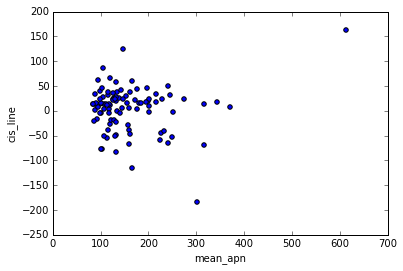

In [60]:
meanByMsLine.plot(kind='scatter', x='mean_apn', y='cis_line')

In [68]:
def cisAPN(df, fusion, value='cis_line', xcutoff='>=150', ycutoff='<=-180'):
    """ Plot effects vs mean apn"""
    # Pull out fusion of interest
    dfSub = marenRawCounts[marenRawCounts['fusion_id'] == fusion]

    # Make scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    dfSub.plot(kind='scatter', x='mean_apn', y='cis_line', ax=ax, title=fusion)

    # Annotate outliers
    xc = 
    filt = dfSub.loc[(dfSub[value] eval(ycutoff)) | (dfSub['mean_apn'] eval(xcutoff)), ['line', 'mating_status', 'mean_apn', 'cis_line']]
    for row in filt.values:
        line, ms, apn, cis = row
        ax.annotate(line + '_' + ms, xy=(apn, cis))

    fname = pjoin(PROJ, 'pipeline_output/cis_effects/scatter_plot_{}_{}_v_meanApn.png'.format(fusion, value))
    plt.savefig(fname, bbox_inches='tight')

SyntaxError: invalid syntax (<ipython-input-68-ab89754b1cf2>, line 11)

In [5]:
marenRawCounts.columns

Index([            u'line',    u'mating_status',        u'fusion_id',
       u'flag_AI_combined',    u'q5_mean_theta',         u'sum_both',
               u'sum_line',       u'sum_tester',        u'sum_total',
               u'mean_apn',               u'mu',         u'cis_line',
             u'trans_line',       u'cis_tester',     u'trans_tester',
                u'mag_cis'],
      dtype='object')

In [6]:
mated = marenRawCounts[marenRawCounts['mating_status'] == 'M']

In [8]:
genos = set(mated['line'].tolist())

In [11]:
mated.head()

,line,mating_status,fusion_id,flag_AI_combined,q5_mean_theta,sum_both,sum_line,sum_tester,sum_total,mean_apn,mu,cis_line,trans_line,cis_tester,trans_tester,mag_cis
0,r324,M,F10001_SI,0,0.507,1465,107,104,1676,35.659574,108.7,14,-20.4,11,-11,14
1,r365,M,F10001_SI,0,0.646,1281,67,115,1463,31.127660,108.7,-37,1.6,11,-11,37
2,r373,M,F10001_SI,0,0.589,1743,181,247,2171,46.191489,108.7,-55,265.6,11,-11,55
3,r427,M,F10001_SI,0,0.500,2071,94,88,2253,47.936170,108.7,17,-52.4,11,-11,17
4,r491,M,F10001_SI,0,0.401,2102,74,46,2222,47.276596,108.7,39,-136.4,11,-11,39


In [14]:
grp = mated.groupby('line')

In [17]:
sub = grp.get_group('r324')

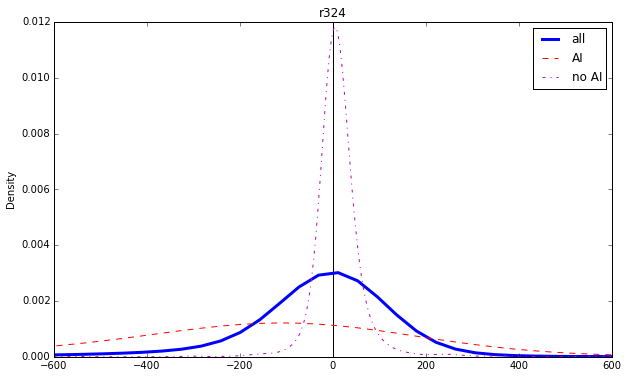

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)
ax.axvline(0, c='k', lw=1)
sub['cis_line'].plot(kind='kde', xlim=(-600, 600), ax=ax, label='all', style='b-', lw=3)
sub.ix[sub['flag_AI_combined'] == 1, 'cis_line'].plot(kind='kde', xlim=(-600, 600), ax=ax, label='AI', style='r--')
sub.ix[sub['flag_AI_combined'] == 0, 'cis_line'].plot(kind='kde', xlim=(-600, 600), ax=ax, label='no AI', style='m-.')
plt.legend()
plt.title('r324')